In [1]:
import gc
import dill
import numpy as np
import pandas as pd
import axelrod as axl
from time import time
from pprint import pprint
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
pd.options.display.float_format = "{:,.2f}".format

# the following imports are from network / axl_utils folder
import network
from network.dqn import DQN
from network.replay import ReplayMemory
from axl_utils.nnplayer import NNplayer, State
from axl_utils.game import *

In [2]:
C = axl.Action.C
D = axl.Action.D

# config game rules
# doubled game length for some extra complexity
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

### this stage will use axl.tournament function to let our DQN play against multiple strategies

Detailed documentation and more strategies can be found here: https://axelrod.readthedocs.io/en/stable/_modules/index.html

In [3]:
from axl_utils.tournament import Tournament

In [4]:
# to create a complex environment
# I'm trying to encourage provocative defection     (against cooperative strategies)
# and retaliative defection                         (against provocative)
# while at the same time punish excessive defection (against retaliative)

cooperative = (axl.Cooperator(), axl.TitFor2Tats())
provocative = (axl.Prober(), axl.Prober4(), axl.RemorsefulProber())
retaliative = (axl.TitForTat(), axl.Grudger(), axl.Punisher())
noise       = ()  #(axl.Random(), axl.Alternator())

players = [*cooperative, *provocative, *retaliative, *noise]
tournament = Tournament(players, game=GAME, turns=GAME_LEN)
results = tournament.play()

Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 133.67it/s]


In [5]:
# tournament result
# explanation of the elements can be found here: https://axelrod.readthedocs.io/en/stable/tutorials/advanced/tournament_results.html
summary = results.summarise()
headers = "Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate".split(',')
pd.DataFrame(map(list, summary), columns=headers)

# median score is based on normalized score, which represent the average return for each turn
# e.g. if 2 player cooperates the whole game, this should be 3.00 for both

,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,Tit For Tat,2.84,0.89,0.00,1.00,0.79,0.10,0.09,0.03,1.00,0.00,1.00,0.00
1,1,Punisher,2.61,0.69,2.00,1.00,0.67,0.02,0.08,0.24,1.00,0.00,0.00,0.00
2,2,Remorseful Prober: 0.1,2.59,0.68,2.50,1.00,0.54,0.14,0.17,0.15,0.91,0.00,0.91,0.52
3,3,Grudger,2.56,0.67,2.00,1.00,0.65,0.02,0.08,0.26,1.00,0.00,0.00,0.00
4,4,Tit For 2 Tats,2.48,0.87,0.00,1.00,0.76,0.11,0.02,0.11,1.00,0.77,1.00,0.00
5,5,Prober 4,2.40,0.50,4.00,1.00,0.23,0.27,0.30,0.20,0.35,0.34,0.75,0.71
6,6,Cooperator,2.38,1.00,0.00,1.00,0.79,0.21,0.00,0.00,1.00,1.00,0.00,0.00
7,7,Prober,2.37,0.36,2.00,0.00,0.23,0.13,0.26,0.38,0.80,0.54,0.77,0.00


In [6]:
dqn = DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 300),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(300, 150),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(150, 80),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(80, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ],
            ReplayMemory(8000), gamma=0.9, greedy=0.2)
p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 3e-5, 'batch': 32, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l2', 1e-3), "loss_fn":"mse"}

In [7]:
from random import shuffle     

def train_against(trainee, trainers, iterations=40):
    shuffle(trainers)
    for trainer in trainers:
        for _  in range(iterations):
            play(trainee, trainer, show=False)

In [8]:
train_against(p1, players)
len(p1.network.memory)      # 21(turns) * 10(# of players) * 40(iterations)

6720

In [ ]:
# train loop as usual
for _ in range(10):
    start = time()
    p1.train(30, param)
    
    train_against(p1, players)
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')

In [ ]:
p1.plot()
# but it seems our policy net didn't get enough training before the target net is updated
# causing the divergence we've seen in stage 1 section 2

# evident by the cyclic, overall upward trend in loss:

In [9]:
p1.network.reset()

param = {"lr": 1=3e-5, 'batch': 32, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l2', 1e-3), "loss_fn":"mse"}

Network reinitialized.


In [9]:
# time to take a nap
ls = []
loss_ls = []
for i in range(100):
    
    start = time()
    p1.train(250, param, loss_targ=0.02)
    
    train_against(p1, players)
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # test DQN in tournament
    if i % 2 == 0:
        loss_ls.append(np.sum(p1.network.loss))
        with p1:
            p1.network.verbosity = False
            tournament = Tournament([p1, *players], game=GAME, turns=GAME_LEN)
            results = tournament.play()
            summary = results.summarise()
            ls.append(pd.DataFrame(map(list, summary), columns=headers))
               
        # backing up
        with open('data/s2/tn_results.pkl', "wb") as file:
            dill.dump(ls, file)

        with open(f'data/s2/p1_{i}.pkl', "wb") as file:
            dill.dump(p1, file)

loss: [0.395 0.422],            time: +107.32 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 151.52it/s]


loss: [0.281 0.355],            time: +250.88 sec
loss: [0.573 0.398],            time: +124.50 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 158.20it/s]


loss: [0.583 0.468],            time: +146.43 sec
loss: [0.57  0.477],            time: +139.14 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 168.89it/s]


loss: [0.62  0.506],            time: +168.57 sec
loss: [0.411 0.604],            time: +318.33 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 149.67it/s]


loss: [0.822 0.4  ],            time: +216.74 sec
loss: [0.582 0.364],            time: +266.45 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 167.79it/s]


loss: [0.633 0.497],            time: +129.04 sec
loss: [0.666 0.731],            time: +147.37 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 159.24it/s]


loss: [1.053 0.607],            time: +164.02 sec
loss: [0.76  0.662],            time: +117.56 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 159.58it/s]


loss: [0.966 0.553],            time: +308.58 sec
loss: [1.077 0.656],            time: +214.18 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 158.23it/s]


loss: [1.053 0.437],            time: +341.02 sec
loss: [0.752 0.581],            time: +170.64 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 162.34it/s]


loss: [0.609 0.384],            time: +182.10 sec
loss: [0.649 0.525],            time: +343.07 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 164.48it/s]


loss: [0.918 0.571],            time: +175.80 sec
loss: [0.773 0.975],            time: +133.07 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 143.67it/s]


loss: [0.973 0.784],            time: +284.90 sec
loss: [1.292 0.651],            time: +141.84 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 168.92it/s]


loss: [0.827 0.501],            time: +154.71 sec
loss: [0.652 0.9  ],            time: +169.34 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 161.30it/s]


loss: [0.778 0.807],            time: +151.56 sec
loss: [0.965 0.614],            time: +345.84 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.63it/s]


loss: [0.558 0.806],            time: +346.40 sec
loss: [0.804 0.561],            time: +156.98 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 162.34it/s]


loss: [0.874 0.565],            time: +346.11 sec
loss: [1.153 0.714],            time: +149.98 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 165.53it/s]


loss: [0.733 0.819],            time: +213.94 sec
loss: [0.756 0.65 ],            time: +130.71 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 161.27it/s]


loss: [0.767 0.696],            time: +148.40 sec
loss: [0.741 0.649],            time: +335.80 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 170.07it/s]


loss: [0.496 0.555],            time: +251.72 sec
loss: [0.573 0.762],            time: +268.60 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 162.31it/s]


loss: [0.722 0.604],            time: +235.42 sec
loss: [0.413 0.441],            time: +294.44 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 137.36it/s]


loss: [0.852 0.803],            time: +169.25 sec
loss: [0.574 0.625],            time: +351.80 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 135.88it/s]


loss: [0.625 0.468],            time: +348.06 sec
loss: [1.054 0.7  ],            time: +348.44 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 158.23it/s]


loss: [1.532 0.664],            time: +219.87 sec
loss: [1.091 0.48 ],            time: +351.47 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 170.04it/s]


loss: [0.518 0.763],            time: +264.90 sec
loss: [0.966 0.698],            time: +158.24 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 171.23it/s]


loss: [1.237 0.428],            time: +25640.92 sec


KeyboardInterrupt: 

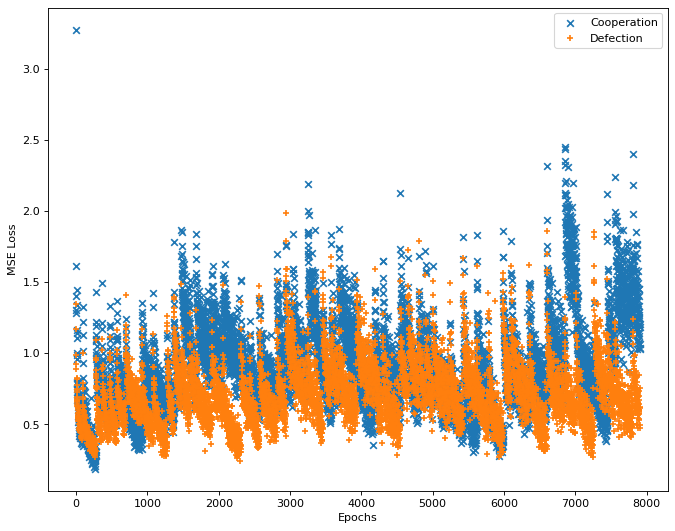

In [10]:
p1.plot()

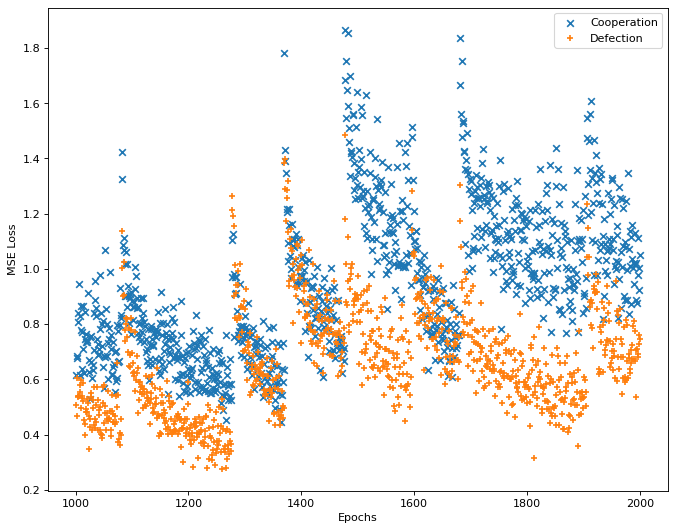

In [14]:
p1.plot(min_ran=1000,max_ran=2000)

In [11]:
[x.set_index('Name', inplace=True) for x in ls];

In [13]:
things = ['Rank', 'Median_score', 'Cooperation_rating', 'Initial_C_rate', 'CC_to_C_rate', 'CD_to_C_rate']
pd.DataFrame([[l.loc['DQN',t] for t in things] for l in ls], columns=things)

,Rank,Median_score,Cooperation_rating,Initial_C_rate,CC_to_C_rate,CD_to_C_rate
0,8,1.95,0.00,0.00,0.00,0.00
1,3,2.61,0.60,1.00,0.52,0.68
2,6,2.37,0.39,0.00,0.50,0.36
3,1,2.63,0.49,1.00,0.49,0.48
4,1,2.77,0.74,1.00,0.88,0.37
5,1,2.75,0.37,0.00,0.66,0.68
6,1,2.74,0.40,0.00,0.69,0.71
7,0,2.87,0.60,1.00,0.71,0.64
8,0,2.88,0.63,1.00,0.81,0.81
9,0,2.84,0.51,1.00,0.53,0.42


In [16]:
ls[42]

,Rank,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
Name,,,,,,,,,,,,,
NNplayer,0,2.92,0.82,7.00,1.00,0.74,0.08,0.13,0.05,0.87,0.39,0.52,0.75
Tit For Tat,1,2.84,0.91,0.00,1.00,0.83,0.08,0.07,0.02,1.00,0.00,1.00,0.00
Grudger,2,2.64,0.71,2.00,1.00,0.69,0.02,0.07,0.22,1.00,0.00,0.00,0.00
Remorseful Prober: 0.1,3,2.63,0.70,3.00,1.00,0.57,0.12,0.15,0.15,0.90,0.00,0.86,0.54
Punisher,4,2.58,0.71,2.00,1.00,0.69,0.02,0.07,0.22,1.00,0.00,0.00,0.00
Tit For 2 Tats,5,2.54,0.89,0.00,1.00,0.79,0.09,0.01,0.10,1.00,0.77,1.00,0.00
Cooperator,6,2.42,1.00,0.00,1.00,0.81,0.19,0.00,0.00,1.00,1.00,0.00,0.00
Prober,7,2.37,0.39,2.00,0.00,0.22,0.16,0.27,0.34,0.83,0.46,0.80,0.00
Prober 4,8,2.34,0.50,3.50,1.00,0.22,0.28,0.29,0.21,0.39,0.32,0.74,0.71


In [17]:
ls[11]

,Rank,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
Name,,,,,,,,,,,,,
NNplayer,0,2.95,0.80,7.00,1.00,0.74,0.07,0.14,0.06,0.92,0.53,0.48,0.83
Tit For Tat,1,2.83,0.90,0.00,1.00,0.81,0.09,0.08,0.02,1.00,0.00,1.00,0.00
Grudger,2,2.62,0.71,2.00,1.00,0.68,0.03,0.07,0.22,1.00,0.00,0.00,0.00
Punisher,3,2.61,0.70,2.00,1.00,0.68,0.02,0.07,0.23,1.00,0.00,0.00,0.00
Remorseful Prober: 0.1,4,2.57,0.67,3.50,1.00,0.53,0.14,0.17,0.16,0.88,0.00,0.94,0.51
Tit For 2 Tats,5,2.55,0.89,0.00,1.00,0.80,0.09,0.01,0.10,1.00,0.81,1.00,0.00
Cooperator,6,2.43,1.00,0.00,1.00,0.81,0.19,0.00,0.00,1.00,1.00,0.00,0.00
Prober,7,2.40,0.41,2.00,0.00,0.27,0.14,0.25,0.33,0.83,0.49,0.80,0.00
Prober 4,8,2.25,0.50,4.00,1.00,0.22,0.28,0.27,0.23,0.36,0.34,0.72,0.72


In [26]:
with open('data/s2/p1_22.pkl', "rb") as file:
    p2 = dill.load(file)

In [38]:
with p2:
    p2.network.verbosity = False
    tournament = Tournament([p2, *players], game=GAME, turns=GAME_LEN)
    results = tournament.play()
    summary = results.summarise()
pd.DataFrame(map(list, summary), columns=headers)

,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,NNplayer,2.97,0.81,7.00,1.00,0.75,0.06,0.13,0.06,0.93,0.55,0.42,0.89
1,1,Tit For Tat,2.83,0.89,0.00,1.00,0.80,0.10,0.08,0.02,1.00,0.00,1.00,0.00
2,2,Punisher,2.62,0.71,2.00,1.00,0.69,0.02,0.07,0.22,1.00,0.00,0.00,0.00
3,3,Remorseful Prober: 0.1,2.61,0.68,3.00,1.00,0.54,0.14,0.16,0.16,0.89,0.00,0.89,0.47
4,4,Grudger,2.58,0.71,2.00,1.00,0.68,0.02,0.07,0.23,1.00,0.00,0.00,0.00
5,5,Tit For 2 Tats,2.56,0.89,0.00,1.00,0.80,0.09,0.01,0.10,1.00,0.81,1.00,0.00
6,6,Cooperator,2.43,1.00,0.00,1.00,0.81,0.19,0.00,0.00,1.00,1.00,0.00,0.00
7,7,Prober,2.40,0.41,2.00,0.00,0.27,0.14,0.25,0.33,0.83,0.49,0.80,0.00
8,8,Prober 4,2.24,0.50,4.00,1.00,0.22,0.28,0.27,0.23,0.36,0.34,0.72,0.72


In [16]:
a = pd.DataFrame([l.loc['DQN','Median_score'] for l in ls]).to_numpy().T[0]
b = pd.DataFrame([l.loc['Tit For Tat','Median_score'] for l in ls]).to_numpy().T[0]

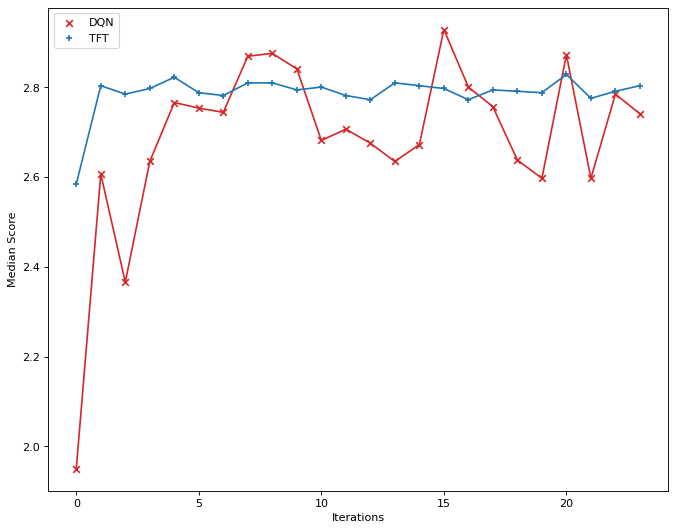

In [18]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(range(len(a)), a, c='tab:red', marker='x', label='DQN')
plt.plot(range(len(a)), a, c='tab:red')
plt.scatter(range(len(a)), b, c='tab:blue', marker='+', label='TFT')
plt.plot(range(len(a)), b, c='tab:blue')
plt.legend(loc='upper left')
plt.xlabel('Iterations')
plt.ylabel('Median Score')
plt.show()

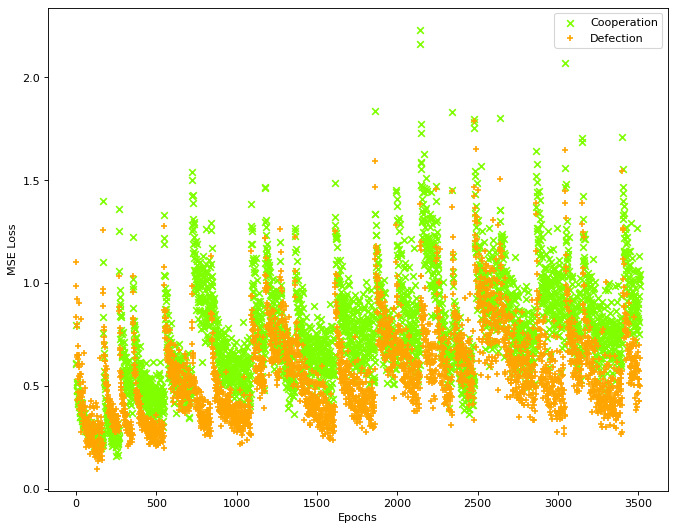

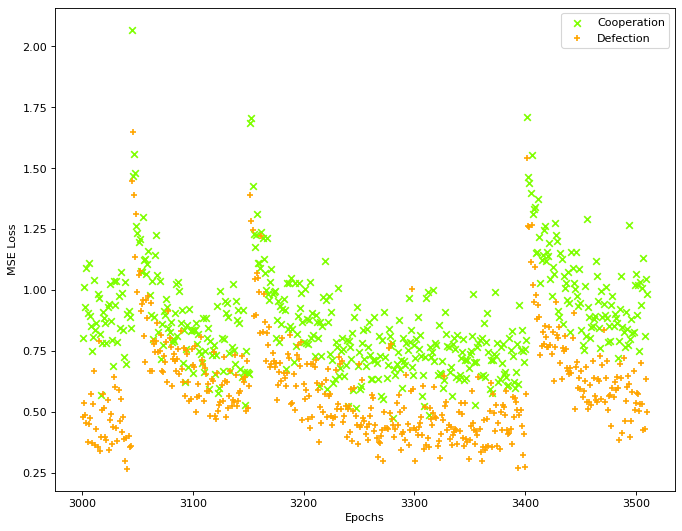

In [40]:
p2.plot()
p2.plot(min_ran=3000)